In [ ]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from numpy import load, zeros, ones, asarray, vstack
from random import random
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
import matplotlib.pyplot as plt

In [3]:
def define_discriminator(im_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=im_shape)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, d)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, loss_weights=[0.5])
    return model

In [4]:
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g

In [5]:
def define_generator(image_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('tanh')(g)
    model = Model(in_image, g)
    return model

In [6]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = True
    
    #adverserial loss
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    
    #identity loss
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    
    #cycle loss forward
    output_f = g_model_2(gen1_out)
    
    #cycle loss backward
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [7]:
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = X1 - 127.5 / 127.5
    X2 = X2 - 127.5 / 127.5
    return [X1, X2]

def generate_real_samples(dataset, n_samples, patch_shape):
    idx = randint(0, dataset.shape[0], patch_shape)
    X = dataset[idx]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [8]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step+1)
    g_model_BtoA.save(filename2)
    print('Saved: %s and %s' %(filename1, filename2))

def summarize_performance(step, g_model, trainX, name, n_samples=5):
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    
    X_in = X_in + 1 / 2.0
    X_out = X_out + 1 / 2.0
    
    for i in range(n_samples):
        plt.subplot(2, n_samples, i+1)
        plt.axis('off')
        plt.imshow(X_in[i])
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+n_samples+i)
        plt.axis('off')
        plt.imshow(X_out[i])
        
    filename = '%s_generated_plot_%06d.png' %(name, (step+1))
    plt.savefig(filename)
    plt.close()

In [9]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            idx = randint(0, len(pool))
            selected.append(pool[idx])
            pool[idx] = image
    return asarray(selected)

In [10]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    n_epochs, n_batch, = 10, 1
    n_patch = d_model_A.output_shape[1]
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)

        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            save_models(i, g_model_AtoB, g_model_BtoA)

In [11]:
from os import listdir
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from sklearn.utils import resample
from datetime import datetime
tf.data.Dataset.from_tensor_slices

In [13]:
def load_images(path, size=(256,256)):
    data_list = list()
    for filename in listdir(path):
        pic = load_img(path+filename, target_size=size)
        pic = img_to_array(pic)
        data_list.append(pic)
    return asarray(data_list)

In [14]:
path = 'monet2photo/'
dataA_ = load_images(path + 'trainA/')
print('dataA shape', dataA_.shape)
dataB_ = load_images(path + 'trainB/')
print('dataB shape', dataB_.shape)

dataA = resample(dataA_, replace=False, n_samples=1000, random_state=2)
dataB = resample(dataB_, replace=False, n_samples=1000, random_state=2)

dataA shape (1072, 256, 256, 3)
dataB shape (6287, 256, 256, 3)


In [15]:
filename = 'monet2photo.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Saved dataset:  monet2photo.npz


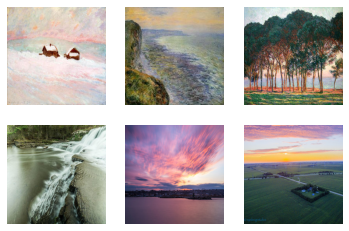

In [14]:
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
    
for i in range(3):
    plt.subplot(2,3,i+1+3)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [16]:
dataset = load_real_samples('monet2photo.npz')
image_shape = dataset[0].shape[1:]
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
start_time = datetime.now()
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)
stop_time = datetime.now()
print('Execution time:', stop_time - start_time)